In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import pyarrow.parquet as pq

def find_root():
    root = Path.cwd().resolve()
    for _ in range(8):
        if (root / "data").exists():
            return root
        root = root.parent
    raise FileNotFoundError("No encuentro /data. Abre el notebook dentro del repo.")

ROOT = find_root()
PARQ = ROOT / "data" / "gold" / "bicing_gold_ml_features_tplus1.parquet"
PARQ


WindowsPath('C:/Users/patxi/Documents/GitHub/bicing-barcelona-ml/data/gold/bicing_gold_ml_features_tplus1.parquet')

In [2]:
cols = [
    "station_id","time_hour",
    "bikes_available_mean","docks_available_mean","mechanical_mean","ebike_mean","obs_count",
    "hour","dayofweek","month","is_weekend",
    "temperature_2m","relative_humidity_2m","precipitation","wind_speed_10m","pressure_msl",
    "lag_1h_bikes","lag_2h_bikes","lag_24h_bikes","roll3h_bikes_mean",
    "holiday_any","holiday_scope_final",
    "sin_hour","cos_hour","sin_dow","cos_dow",
    "is_rain","is_heavy_rain","is_windy",
    "y_bikes_tplus1"
]

# OJO: si esto te peta de RAM, bajamos a 300k
N = 1_000_000

t = pq.read_table(PARQ, columns=cols)
df = t.to_pandas()

# sample reproducible (sin mezclar demasiado la distribución temporal)
df = df.sample(n=min(N, len(df)), random_state=42)

df["time_hour"] = pd.to_datetime(df["time_hour"])
df.shape


(1000000, 30)

In [3]:
# Filtra filas con NaNs en features clave (los lags al principio de series)
before = len(df)
df = df.dropna(subset=["lag_1h_bikes","lag_24h_bikes","roll3h_bikes_mean","y_bikes_tplus1"])
after = len(df)
print("rows:", before, "->", after)

# target y
y = df["y_bikes_tplus1"].astype(float)


rows: 1000000 -> 967302


In [4]:
X = df.drop(columns=["y_bikes_tplus1", "time_hour"])

# one-hot para holiday_scope_final
X = pd.get_dummies(X, columns=["holiday_scope_final"], dummy_na=False)

X.shape


(967302, 31)

In [5]:
# Split por fecha (ejemplo: test = 2025)
df_split = df[["time_hour"]].copy()
cut = pd.Timestamp("2025-01-01 00:00:00")

train_idx = df["time_hour"] < cut
test_idx  = df["time_hour"] >= cut

X_train, y_train = X.loc[train_idx], y.loc[train_idx]
X_test,  y_test  = X.loc[test_idx],  y.loc[test_idx]

X_train.shape, X_test.shape


((844458, 31), (122844, 31))

In [9]:
!pip install scikit-learn

  Using cached scikit_learn-1.8.0-cp312-cp312-win_amd64.whl.metadata (11 kB)
  Using cached scipy-1.17.0-cp312-cp312-win_amd64.whl.metadata (60 kB)
  Using cached joblib-1.5.3-py3-none-any.whl.metadata (5.5 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.8.0-cp312-cp312-win_amd64.whl (8.0 MB)
Using cached joblib-1.5.3-py3-none-any.whl (309 kB)
Using cached scipy-1.17.0-cp312-cp312-win_amd64.whl (36.3 MB)
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)

   ---------- ----------------------------- 1/4 [scipy]
   ---------- ----------------------------- 1/4 [scipy]
   ---------- ----------------------------- 1/4 [scipy]
   ---------- ----------------------------- 1/4 [scipy]
   ---------- ----------------------------- 1/4 [scipy]
   ---------- ----------------------------- 1/4 [scipy]
   ---------- ----------------------------- 1/4 [scipy]
   ---------- ----------------------------- 1/4 [scipy]
   ---------- ------------------

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

ridge = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),  # por si hay many-hot / sparse
    ("model", Ridge(alpha=1.0, random_state=42))
])

ridge.fit(X_train, y_train)
pred = ridge.predict(X_test)

mae = mean_absolute_error(y_test, pred)
rmse = root_mean_squared_error(y_test, pred)

mae, rmse


(1.8210957266576944, 2.7090048572437633)

In [ ]:
!pip install tqdm

In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    n_jobs=-1,
    random_state=42
)

rf.fit(X_train, y_train)
pred2 = rf.predict(X_test)

mae2 = mean_absolute_error(y_test, pred2)
rmse2 = root_mean_squared_error(y_test, pred2)

mae2, rmse2


(1.7480691425705535, 2.6065406730268497)

In [15]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

hgb = HistGradientBoostingRegressor(
    max_depth=8,
    max_iter=300,
    learning_rate=0.05,
    random_state=42
)

hgb.fit(X_train, y_train)
pred = hgb.predict(X_test)

mae = mean_absolute_error(y_test, pred)
rmse = root_mean_squared_error(y_test, pred)

mae, rmse


(1.714850270791601, 2.5641794656932673)

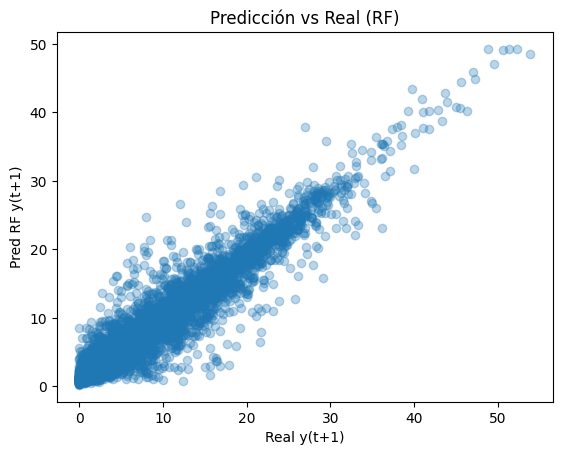

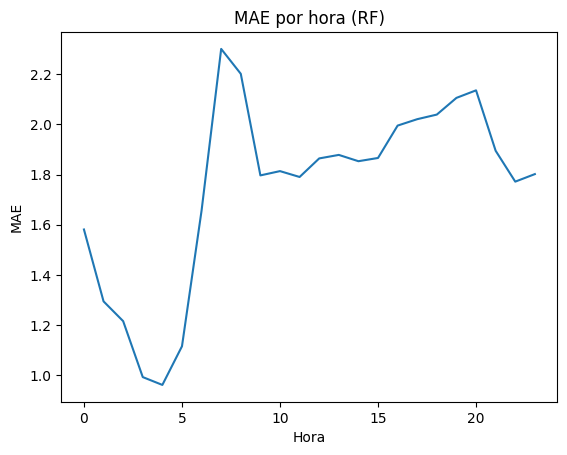

In [14]:
import matplotlib.pyplot as plt

# Pred vs real (sample)
k = min(5000, len(y_test))
idx = np.random.RandomState(42).choice(np.arange(len(y_test)), size=k, replace=False)

plt.figure()
plt.scatter(y_test.iloc[idx], pred2[idx], alpha=0.3)
plt.xlabel("Real y(t+1)")
plt.ylabel("Pred RF y(t+1)")
plt.title("Predicción vs Real (RF)")
plt.show()

# Error por hora
tmp = df.loc[test_idx, ["hour"]].copy()
tmp["abs_err"] = np.abs(y_test.values - pred2)
err_hour = tmp.groupby("hour")["abs_err"].mean()

plt.figure()
plt.plot(err_hour.index, err_hour.values)
plt.xlabel("Hora")
plt.ylabel("MAE")
plt.title("MAE por hora (RF)")
plt.show()


In [18]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

# Asegúrate de que df_test está alineado con y_test
df_test = df.loc[test_idx].copy()

pred_naive1 = df_test["lag_1h_bikes"].values
pred_naive2 = df_test["roll3h_bikes_mean"].values

mae_n1 = mean_absolute_error(y_test, pred_naive1)
rmse_n1 = root_mean_squared_error(y_test, pred_naive1)

mae_n2 = mean_absolute_error(y_test, pred_naive2)
rmse_n2 = root_mean_squared_error(y_test, pred_naive2)

print("NAIVE lag_1h  ->", mae_n1, rmse_n1)
print("NAIVE roll3h ->", mae_n2, rmse_n2)
print("Ridge        ->", mae, rmse)
print("RF           ->", mae2, rmse2)


NAIVE lag_1h  -> 2.863432672314345 4.438148871562925
NAIVE roll3h -> 2.565902951381357 3.918687516643064
Ridge        -> 1.714850270791601 2.5641794656932673
RF           -> 1.7480691425705535 2.6065406730268497


In [19]:
imp = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
imp.head(20)


bikes_available_mean    0.903693
lag_1h_bikes            0.017251
docks_available_mean    0.008489
lag_24h_bikes           0.007351
station_id              0.006134
sin_hour                0.005126
wind_speed_10m          0.005066
lag_2h_bikes            0.005050
temperature_2m          0.005043
pressure_msl            0.005018
roll3h_bikes_mean       0.005003
mechanical_mean         0.004864
relative_humidity_2m    0.004339
ebike_mean              0.003523
hour                    0.002484
cos_hour                0.002400
month                   0.002252
sin_dow                 0.001724
dayofweek               0.001393
obs_count               0.001251
dtype: float64

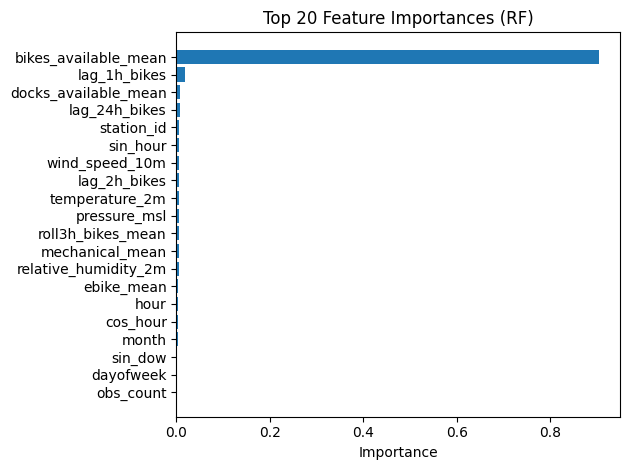

In [20]:
import matplotlib.pyplot as plt

top = imp.head(20)
plt.figure()
plt.barh(top.index[::-1], top.values[::-1])
plt.title("Top 20 Feature Importances (RF)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


MAE RF holiday_any=0: 1.7524840087900193
MAE RF holiday_any=1: 1.6280370547138179
MAE RF heavy_rain=0: 1.7499786524445893
MAE RF heavy_rain=1: 1.6261940450746357
MAE RF windy=0: 1.748549865660234
MAE RF windy=1: 1.6313793354445085


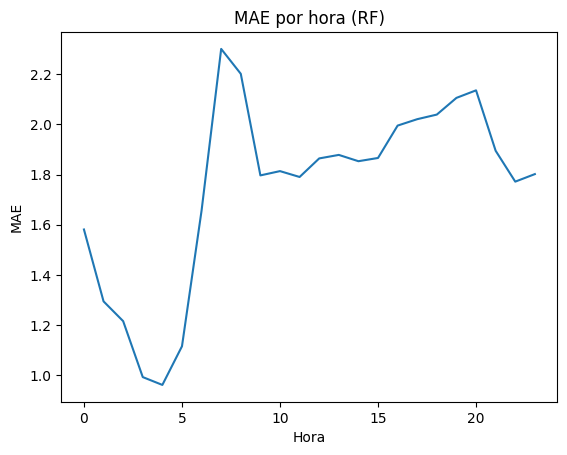

In [21]:
tmp = df_test[["holiday_any","is_heavy_rain","is_windy","hour"]].copy()
tmp["abs_err_rf"] = np.abs(y_test.values - pred2)

print("MAE RF holiday_any=0:", tmp.loc[tmp.holiday_any==0, "abs_err_rf"].mean())
print("MAE RF holiday_any=1:", tmp.loc[tmp.holiday_any==1, "abs_err_rf"].mean())
print("MAE RF heavy_rain=0:", tmp.loc[tmp.is_heavy_rain==0, "abs_err_rf"].mean())
print("MAE RF heavy_rain=1:", tmp.loc[tmp.is_heavy_rain==1, "abs_err_rf"].mean())
print("MAE RF windy=0:", tmp.loc[tmp.is_windy==0, "abs_err_rf"].mean())
print("MAE RF windy=1:", tmp.loc[tmp.is_windy==1, "abs_err_rf"].mean())

mae_by_hour = tmp.groupby("hour")["abs_err_rf"].mean()
plt.figure()
plt.plot(mae_by_hour.index, mae_by_hour.values)
plt.title("MAE por hora (RF)")
plt.xlabel("Hora")
plt.ylabel("MAE")
plt.show()


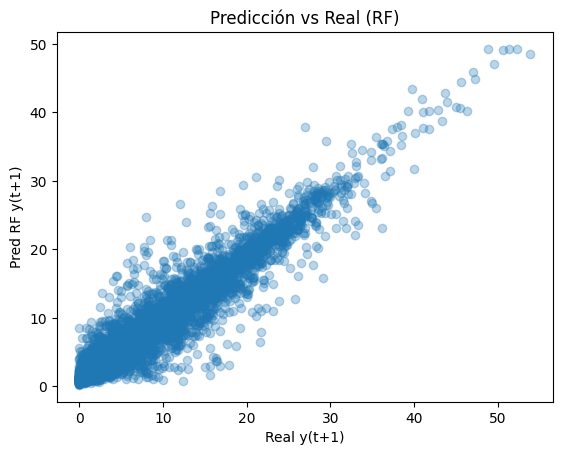

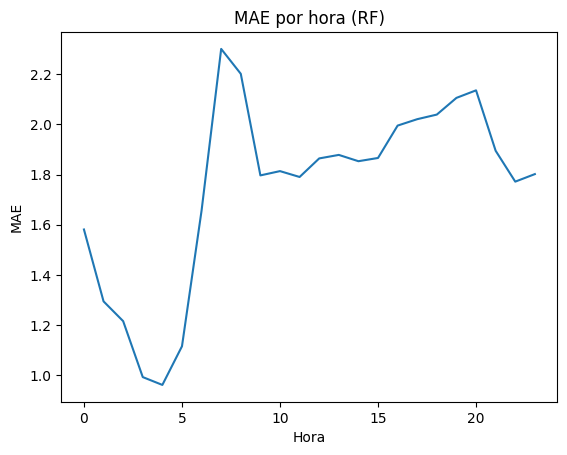

In [ ]:
import matplotlib.pyplot as plt

# Pred vs real (sample)
k = min(5000, len(y_test))
idx = np.random.RandomState(42).choice(np.arange(len(y_test)), size=k, replace=False)

plt.figure()
plt.scatter(y_test.iloc[idx], pred2[idx], alpha=0.3)
plt.xlabel("Real y(t+1)")
plt.ylabel("Pred RF y(t+1)")
plt.title("Predicción vs Real (RF)")
plt.show()

# Error por hora
tmp = df.loc[test_idx, ["hour"]].copy()
tmp["abs_err"] = np.abs(y_test.values - pred2)
err_hour = tmp.groupby("hour")["abs_err"].mean()

plt.figure()
plt.plot(err_hour.index, err_hour.values)
plt.xlabel("Hora")
plt.ylabel("MAE")
plt.title("MAE por hora (RF)")
plt.show()


In [1]:
!pip install joblib



[notice] A new release of pip is available: 26.0 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# 06_train_hgbr_tplus1.py
# Entrena HistGradientBoostingRegressor sobre el parquet de features t+1
# Split temporal (no aleatorio) + métricas + guardado del modelo

from pathlib import Path
import numpy as np
import pandas as pd
import pyarrow.parquet as pq

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import HistGradientBoostingRegressor
import joblib


def find_project_root() -> Path:
    """Sube carpetas hasta encontrar 'data' o '.git'."""
    p = Path.cwd().resolve()
    for _ in range(8):
        if (p / "data").exists() or (p / ".git").exists():
            return p
        p = p.parent
    return Path.cwd().resolve()


def main():
    ROOT = find_project_root()

    INP = ROOT / "data" / "gold" / "bicing_gold_ml_features_tplus1.parquet"
    if not INP.exists():
        raise FileNotFoundError(f"No existe el input: {INP}")

    print("ROOT:", ROOT)
    print("INP :", INP)

    TARGET = "y_bikes_tplus1"

    # Columnas que no vamos a meter como features (para evitar strings / duplicidades)
    DROP_COLS = [
        "date",
        "holiday_scope_final",  # categórica (texto)
        "holiday_name",         # categórica (texto)
    ]

    # Lee parquet
    df = pq.read_table(INP).to_pandas()

    # Tipos
    if "time_hour" in df.columns:
        df["time_hour"] = pd.to_datetime(df["time_hour"], errors="coerce")
    else:
        raise KeyError("Falta 'time_hour' en el parquet. Es necesaria para split temporal.")

    # Target
    if TARGET not in df.columns:
        raise KeyError(
            f"Falta TARGET={TARGET}. Columnas con 'y'/'tplus': "
            f"{[c for c in df.columns if 'y_' in c.lower() or 'tplus' in c.lower()]}"
        )

    # Filtra nulos target
    df = df.dropna(subset=[TARGET]).copy()

    # Ordena por tiempo para split temporal
    df = df.sort_values(["time_hour", "station_id"]).reset_index(drop=True)

    # Features
    drop_existing = [c for c in DROP_COLS if c in df.columns]
    features = [c for c in df.columns if c not in drop_existing + [TARGET]]

    X = df[features].copy()
    y = df[TARGET].copy()

    # Quita no-numéricas (HGBR no acepta strings)
    non_numeric = [c for c in X.columns if not pd.api.types.is_numeric_dtype(X[c])]
    if non_numeric:
        print("⚠️ Quitando columnas no numéricas:", non_numeric)
        X = X.drop(columns=non_numeric)
        features = [c for c in features if c not in non_numeric]

    # Imputación simple (mediana)
    for c in X.columns:
        if X[c].isna().any():
            X[c] = X[c].fillna(X[c].median())

    print("X shape:", X.shape, "| y shape:", y.shape)
    print("n_features:", len(features))
    print("time range:", df["time_hour"].min(), "->", df["time_hour"].max())

    # Split temporal: último 20% del tiempo para test
    split_idx = int(len(df) * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
    t_train_max = df["time_hour"].iloc[split_idx - 1]
    t_test_min = df["time_hour"].iloc[split_idx]

    print("\nSplit temporal:")
    print(" - train rows:", len(X_train), "| hasta:", t_train_max)
    print(" - test  rows:", len(X_test),  "| desde:", t_test_min)

    # Modelo
    model = HistGradientBoostingRegressor(
        loss="squared_error",
        learning_rate=0.08,
        max_depth=None,
        max_iter=400,
        min_samples_leaf=50,
        random_state=42,
    )

    model.fit(X_train, y_train)
    pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, pred)
    rmse = float(np.sqrt(mean_squared_error(y_test, pred)))  # sin squared=

    print("\nHGBR -> MAE:", mae, "| RMSE:", rmse)

    # Guardar métricas
    out_dir = ROOT / "reports" / "tables"
    out_dir.mkdir(parents=True, exist_ok=True)

    out_metrics = out_dir / "ml_hgbr_metrics.txt"
    out_metrics.write_text(
        "\n".join([
            f"MAE={mae}",
            f"RMSE={rmse}",
            f"rows_train={len(X_train)}",
            f"rows_test={len(X_test)}",
            f"train_until={t_train_max}",
            f"test_from={t_test_min}",
            f"n_features={len(features)}",
        ]) + "\n",
        encoding="utf-8"
    )
    print("✅ Métricas guardadas:", out_metrics)

    # Guardar modelo + features
    model_dir = ROOT / "models"
    model_dir.mkdir(parents=True, exist_ok=True)

    out_model = model_dir / "hgbr_tplus1.joblib"
    joblib.dump({"model": model, "features": features}, out_model)
    print("✅ Modelo guardado:", out_model)


if __name__ == "__main__":
    main()


ROOT: C:\Users\patxi\Documents\GitHub\bicing-barcelona-ml
INP : C:\Users\patxi\Documents\GitHub\bicing-barcelona-ml\data\gold\bicing_gold_ml_features_tplus1.parquet
⚠️ Quitando columnas no numéricas: ['time_hour']
X shape: (20984233, 30) | y shape: (20984233,)
n_features: 30
time range: 2019-03-24 14:00:00 -> 2025-12-31 22:00:00

Split temporal:
 - train rows: 16787386 | hasta: 2024-07-15 06:00:00
 - test  rows: 4196847 | desde: 2024-07-15 06:00:00

HGBR -> MAE: 1.7366117675864003 | RMSE: 2.595798124106684
✅ Métricas guardadas: C:\Users\patxi\Documents\GitHub\bicing-barcelona-ml\reports\tables\ml_hgbr_metrics.txt
✅ Modelo guardado: C:\Users\patxi\Documents\GitHub\bicing-barcelona-ml\models\hgbr_tplus1.joblib
